Written by Zain Kamal (zain.eris.kamal@rutgers.edu) on 06/19/2023

https://github.com/Humboldt-Penguin/Mars-Magnetics-Research/tree/main/code

Purpose: 
- Much of our analysis requires large datasets downloaded from external sources. 
    - Previously, data interface classes give you the option to download the raw dataset from google drive (`downloadData` function), load it into a usable format (`loadData` function), and then access/calculate specific values (typically the data is defined on a rectilinear grid representing a map, so we use bilinear interpolation to find values at any specific coordinate).
    - However, we're transitioning to a better method. Rather than manually calculating the bilinear interpolation (slow, unweildy/bloated), we use the `RegularGridInterpolator` from `scipy.interpolate`, which operates as a straightforward callable function. In the case of multiple datasets/quantities, we create a dictionary called `meta_dat` to organize these. Furthermore, we can serialize `meta_dat` with `pickle` library so large datasets don't need to be downloaded and loading is faster.
- We're moving the functionality/responsibility of downloading raw datasets and loading them into a usable format out of the dataset interfaces. However, we still want access to these functionalities in case we want to change what data is downloaded, how it is loaded, and re-serialize. Thus they are included here as a notebook for ease of debugging/exploration.

---
---
# 1. Download/Load Data

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator

import zerisk.Utils as utils
import zerisk.DataDownloader as dd

In [3]:
path__datahome = utils.getPath(r'C:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw')
# Path from root to the directory within which the data folder either (1) already exists, or (2) will be downloaded.
# FIXME: This path is specific to my system. Customize to your own system before use.





gdrive_url = r'https://drive.google.com/drive/folders/17ukcBhiLvy4fVUT10YvSxf25Et2Ovgah?usp=sharing'
# URL from which latest dataset is downloaded using `DataDownloader.py`.


nanval = -1e10
# Value given to pixels where data is not defined (i.e. "NOT_APPLICABLE_CONSTANT"). In the data, this is 9999.999 (see lbl file).


meta_dat = {}
'''
`meta_dat` is formatted as `meta_dat[element_name][quantity]`, where
    - `element_name` is from ['cl','fe','h2o','k','kvsth','si','th']
    - `quantity` is from:
        - 'concentration' = Concentration of the element. 
        - 'sigma' = The error associated with the concentration measurement. 
        - 'sigma_cfs' = The error associated with the concentration measurement. This error includes the errors associated with the correction factors applied to the concentration data if applicable. 

Calling `meta_dat` as such gives a `scipy.interpolate._rgi.RegularGridInterpolator` object, which is a function that takes some [clon,lat] list and returns the linear interpolation of the original dataset to that coordinate.
'''

print()

In [4]:
dd.download_latest(path__datahome=path__datahome, data_name='GRS', url=gdrive_url, overwrite=False, verbose=True)

Data folder already exists at 
C:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\1_raw\GRS. 
To overwrite, add `overwrite=True` param.



In [5]:
path_folder = utils.getPath(path__datahome, 'GRS', 'smoothed')

files = os.listdir(path_folder)

for filename in files:
    if '.tab' not in filename: continue



    '''initialize entry in `meta_dat`'''
    element_name = filename[:filename.index('_')]
    meta_dat[element_name] = {}



    '''import data from files to np.ndarrays'''
    dat = np.loadtxt(utils.getPath(path_folder,filename))
    
    dat = np.where(dat == 9999.999, nanval, dat)

    lat_range = np.unique(dat[:, 0])
    clon_range = np.unique(dat[:, 1])
    # lon_range = utils.clon2lon(clon_range)

    concentration = dat[:, 2].reshape(lat_range.shape[0], clon_range.shape[0]).T
    sigma = dat[:, 3].reshape(lat_range.shape[0], clon_range.shape[0]).T
    sigma_cfs = dat[:, 4].reshape(lat_range.shape[0], clon_range.shape[0]).T
    # NOTE on concentration/sigma/sigma_cfs indexing -- for index (i,j), `i` is longitude from left [0] to right [-1], `j` is latitude from bottom [0] to top [-1]



    '''processing/corrections'''
    if element_name == 'th':
        correction=0.000001 # correct ppm to concentration out of 1
    else:
        correction=0.01 # correct weight percent to concentration out of 1

    concentration = np.where(concentration != nanval, concentration*correction, concentration)
    sigma = np.where(sigma != nanval, sigma*correction, sigma)
    sigma_cfs = np.where(sigma_cfs != nanval, sigma_cfs*correction, sigma_cfs)




    '''edge case: interpolation model does not work for edges where the map "wraps around" (i.e. lon bounds), so we duplicate one extra column on each edge of data/clon_range'''
    spacing = (360-clon_range[-1]) + (clon_range[0]-0)
    clon_range = np.array([clon_range[0]-spacing, *clon_range, clon_range[-1]+spacing])

    left_edge = concentration[0, :]
    right_edge = concentration[-1, :]
    concentration = np.array([right_edge, *concentration, left_edge])

    left_edge = sigma[0, :]
    right_edge = sigma[-1, :]
    sigma = np.array([right_edge, *sigma, left_edge])

    left_edge = sigma_cfs[0, :]
    right_edge = sigma_cfs[-1, :]
    sigma_cfs = np.array([right_edge, *sigma_cfs, left_edge])



    '''declare interpolation function'''
    meta_dat[element_name]['concentration'] = RegularGridInterpolator((clon_range, lat_range), concentration)
    meta_dat[element_name]['sigma'] = RegularGridInterpolator((clon_range, lat_range), sigma)
    meta_dat[element_name]['sigma_cfs'] = RegularGridInterpolator((clon_range, lat_range), sigma_cfs)

In [6]:
meta_dat

{'cl': {'concentration': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7ca81850>,
  'sigma': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7db70110>,
  'sigma_cfs': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7c83d3d0>},
 'fe': {'concentration': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7de429d0>,
  'sigma': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7f7011d0>,
  'sigma_cfs': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7e3e5690>},
 'h2o': {'concentration': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7d888690>,
  'sigma': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7fc82990>,
  'sigma_cfs': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7fc83490>},
 'kvsth': {'concentration': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7fc83b10>,
  'sigma': <scipy.interpolate._rgi.RegularGridInterpolator at 0x1ce7fc83990>,
  'sigma_cfs': <scipy.interpolate._rgi.RegularGridInterpolator at 0

---
---
# 2. Verify functionality

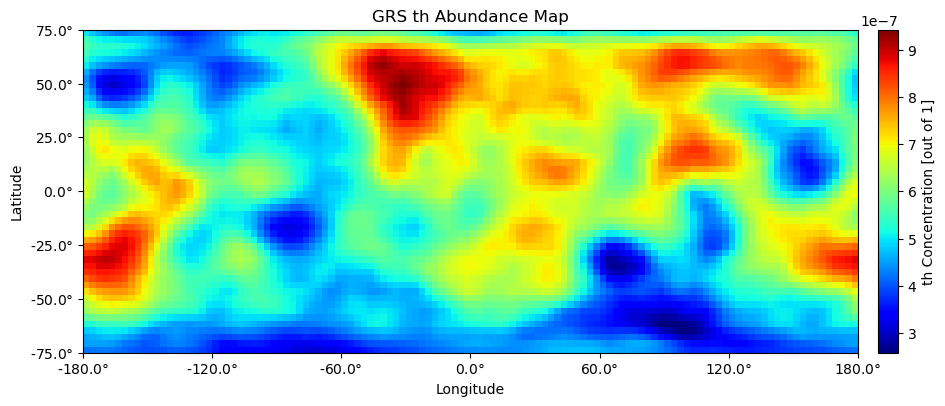

In [8]:
dat = []

lon_left = -180
lon_right = 180
lat_bottom = -75
lat_top = 75

element_name = 'th'
resolution = 3


for lat in np.arange(lat_bottom, lat_top, resolution):
    newline = []
    for lon in np.arange(lon_left, lon_right, resolution):

        '''modify this line to change value being plotted'''
        clon = utils.lon2clon(lon)
        val = meta_dat[element_name]['concentration']([clon,lat])[0]

        newline.append(val)
    dat.append(newline)


'''apply mask'''
dat = np.asarray(dat)
dat = np.ma.masked_where((dat <= 0), dat)



'''primary plot'''
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

'''titles'''
ax.set_title(f'GRS {element_name} Abundance Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

'''axis formatter'''
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.yaxis.set_major_formatter('{x}$\degree$')


'''x ticks'''
'''Option 1: Set the spacing between x ticks'''
# x_spacing = 60
# ax.set_xticks(np.linspace(lon_left, lon_right, int((lon_right-lon_left)/x_spacing)+1))
'''Option 2: Set the number of x ticks'''
x_ticks = 7
ax.set_xticks(np.linspace(lon_left, lon_right, x_ticks))

'''y ticks'''
'''Option 1: Set the spacing between y ticks'''
# y_spacing = 25
# ax.set_yticks(np.linspace(lat_bottom, lat_top, int((lat_top-lat_bottom)/y_spacing)+1))
'''Option 2: Set the number of y ticks'''
y_ticks = 7
ax.set_yticks(np.linspace(lat_bottom, lat_top, y_ticks))

'''color bar'''
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(f'{element_name} Concentration [out of 1]', y=0.5)

plt.show()

---
---
# 3. Serialize/save with `pickle`

In [9]:
dataset_name = 'GRS'



# path_datadir = utils.getPath(r'C:\Users\Eris\Documents\sync_local\01_Research\Mars_Magnetics\code\05_mag_src_map\src\data\2_interim\pickled', dataset_name)
path_datadir = utils.getPath('current')
path_datafile = utils.getPath(path_datadir, (dataset_name+'_meta_dat.pkl'))

os.makedirs(path_datadir, exist_ok=True)

with open(path_datafile, "wb") as file:
    pickle.dump(meta_dat, file)

---
---
# 4. Verify picklefile

In [10]:
with open(path_datafile, "rb") as file:
    meta_dat_pickled = pickle.load(file)

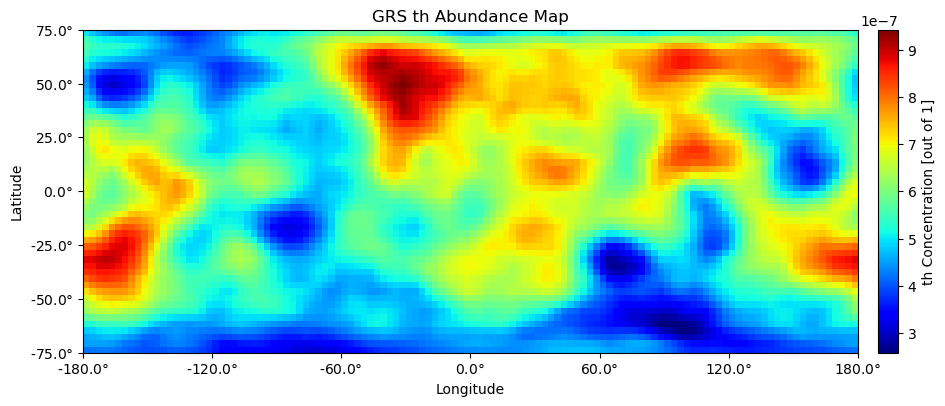

In [12]:
dat = []

lon_left = -180
lon_right = 180
lat_bottom = -75
lat_top = 75

element_name = 'th'
resolution = 3


for lat in np.arange(lat_bottom, lat_top, resolution):
    newline = []
    for lon in np.arange(lon_left, lon_right, resolution):

        '''modify this line to change value being plotted'''
        clon = utils.lon2clon(lon)
        val = meta_dat_pickled[element_name]['concentration']([clon,lat])[0]

        newline.append(val)
    dat.append(newline)


'''apply mask'''
dat = np.asarray(dat)
dat = np.ma.masked_where((dat <= 0), dat)



'''primary plot'''
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
im = ax.imshow(dat[::-1], cmap='jet', extent=[lon_left, lon_right, lat_bottom, lat_top])

'''titles'''
ax.set_title(f'GRS {element_name} Abundance Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

'''axis formatter'''
ax.xaxis.set_major_formatter('{x}$\degree$')
ax.yaxis.set_major_formatter('{x}$\degree$')


'''x ticks'''
'''Option 1: Set the spacing between x ticks'''
# x_spacing = 60
# ax.set_xticks(np.linspace(lon_left, lon_right, int((lon_right-lon_left)/x_spacing)+1))
'''Option 2: Set the number of x ticks'''
x_ticks = 7
ax.set_xticks(np.linspace(lon_left, lon_right, x_ticks))

'''y ticks'''
'''Option 1: Set the spacing between y ticks'''
# y_spacing = 25
# ax.set_yticks(np.linspace(lat_bottom, lat_top, int((lat_top-lat_bottom)/y_spacing)+1))
'''Option 2: Set the number of y ticks'''
y_ticks = 7
ax.set_yticks(np.linspace(lat_bottom, lat_top, y_ticks))

'''color bar'''
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(f'{element_name} Concentration [out of 1]', y=0.5)

plt.show()